# COS/PSY 454 Final Project

## Resources

[Conditional-value-at-risk (CVAR) paper](https://www.sciencedirect.com/science/article/abs/pii/S0022249621000857)
- Fig. 5: Risk-sensitive optimal policies in a 2-D problem

[CVaR Repository](https://github.com/crgagne/cvar_jmathpsych_2021)

[Simplified mental representations to plan](https://www.nature.com/articles/s41586-022-04743-9)

## Imports

In [1]:
# Basics 
import numpy as np
import sys
import pickle
import os

# plotting 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline 
from IPython.display import Image,display
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap

# Scipy 
import scipy 
import scipy.stats
from scipy.optimize import minimize
from scipy.stats import truncnorm
from scipy.optimize import linprog
from scipy.io import loadmat

from scipy.stats import ttest_ind
from scipy.stats import f_oneway

import random

In [2]:
np.random.seed(2)

In [3]:
# necessary paths
sys.path.append('/Users/katiemclaughlin/Downloads/cvar')
sys.path.append('/Users/katiemclaughlin/Downloads/cvar/policy_optimization')
sys.path.append('/Users/katiemclaughlin/Downloads/cvar/shared')
sys.path.append('/Users/katiemclaughlin/Downloads/cvar/plotting')

from nCVaR_Value_Iteration import nCVaR_VI
from pCVaR_Value_Iteration import pCVaR_VI
from scenarios import Agent, setup_params
from shared import induce_P

from matpy_conversions import convert_SI_function, convert_SIA_function
from plotting_basics import plot_q_or_pi, embellish_plot
from plotting_twoD import plot_2D_arrows

## Load MDP from MATLAB

In [4]:
# load old matlab results, which have useful info for MDP
mat = loadmat('./simulation_results/2D_optimal_policy.mat')

# Unpack 
Ny = mat['Y_set_all'].shape[1]
Ns = mat['Y_set_all'].shape[0] # could subtract one here 
Na = 4
gamma = mat['dis'][0][0]
y_set = mat['Y_set_all'][0,:]
P = mat['P']
r = mat['r']
print(P.shape)
print("x,x',a")
y_set

(36, 36, 4)
x,x',a


array([0.  , 0.05, 0.1 , 0.3 , 0.6 , 1.  ])

### Modifying full environment

In [5]:
# fill lava pits in rewards
for pit in (9, 14, 19, 24):
    r[pit,:] = r[0,:]

# add new (weighted) lava pits in rewards
r[15,:] = np.repeat(-1, 4)
r[18,:] = np.repeat(-4, 4)
r[29,:] = 3 * r[29,:] 
r[31,:] = np.repeat(-2, 4)

# make copies of full 
r_orig = r.copy()

# fill in pit if necessary
# r[18,:] = r[0,:]

In [6]:
r

array([[ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [-1, -1, -1, -1],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [-4, -4, -4, -4],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [-3, -3, -3, -3],
       [ 0,  0,  0,  0],
       [-2, -2, -2, -2],
       [ 0,  0,  0,  0],
       [ 3,  3,  3,  3],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0]], dtype=int16)

In [7]:
P_temp = np.copy(P)

In [8]:
# TRANSITION PROBABILITY MATRIX

p93 = P_temp[0][0][0]
p6 = P_temp[0][0][1]
p3 = P_temp[0][1][0]

t_left = P_temp[5][0]
t_right = P_temp[0][5]
t_up = P_temp[1][0]
t_down = P_temp[0][1]

t_pit = P_temp[9]

# set probability transitions 
P[9][9] = [p6, p93, p6, p93]
P[9][8] = t_up
P[9][14] = t_right
P[9][35] = np.repeat(0, 4) # no longer a pit

for y in (14, 19, 24): 
    P[y][y] = t_down
    P[y][y-5] = t_left
    P[y][y-1] = t_up
    P[y][y+5] = t_right
    P[y][35] = np.repeat(0, 4) # no longer a pit

# new pit alert !!
P[15] = t_pit 
P[18] = t_pit 
P[29] = t_pit
P[31] = t_pit 

# make a copy
P_orig = P.copy()

# potentially fill pit
'''
y = 18
P[y][y] = np.repeat(0, 4)
P[y][y-5] = t_left
P[y][y+5] = t_right
P[y][y-1] = t_up
P[y][y+1] = t_down
P[y][35] = np.repeat(0, 4)
'''

'\ny = 18\nP[y][y] = np.repeat(0, 4)\nP[y][y-5] = t_left\nP[y][y+5] = t_right\nP[y][y-1] = t_up\nP[y][y+1] = t_down\nP[y][35] = np.repeat(0, 4)\n'

In [9]:
# check all states in prob matrix, ensure sum to 4
for i in range(36):
    temp_sum = np.sum(P[i])
    if temp_sum != 4:
        print(i)

In [10]:
testcase = 1
p,maze = setup_params(testcase) 
#agent = setup_agent_and_MDP(p,maze) 
maze[4,0]=1
maze[4,6]=1

agent = Agent({'num_states':Ns-1,
               'num_actions':Na,
               'start_states':[4],'r_params':p['r_params']},maze)

## Running nCVaR (nested) Value Iteration

In [20]:
# Run Policy Iteration
V0 = np.repeat((mat['V_Exp']/10),Ny,1);
P_full = np.repeat(P[:,:,np.newaxis,:],Ny,axis=2) # broadcast across Y dimension
r_x = r[:,0]

(Vd,Qd,Xid,Pid,V_storaged,Q_storaged,Xi_storaged,
 pointwise_errord,V_convergedd,multi_startsd) = nCVaR_VI(V0,
            Ns,Ny,Na,
            P_full,
            gamma,
            y_set,
            r_x, # only per state 
            check_pointwise_iters=3,
            pointwise_window=3,
            min_multi_starts=5,
            max_multi_starts=5,
            max_iters=100,
            verbose=False,
            converg_thresh = 10e-5,
            yi_pr=None,
            converg_type = 'full_eval')

/Users/katiemclaughlin/opt/anaconda3/envs/psy454/lib/python3.7/site-packages/scipy/optimize/optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)


--- 1237.5012938976288 seconds ---


### Save

In [86]:
# fname = '/Users/katiemclaughlin/Downloads/cvar/simulation_results/2D_optimal_policy_nCVaR_hm_134.npz'
fname = '/Users/katiemclaughlin/Downloads/cvar/simulation_results/2D_optimal_policy_nCVaR_duh_134.npz' 
# fname = '/Users/katiemclaughlin/Downloads/cvar/simulation_results/2D_optimal_policy_nCVaR.npz'
fname

'/Users/katiemclaughlin/Downloads/cvar/simulation_results/2D_optimal_policy_nCVaR_duh_134.npz'

In [102]:
#np.savez(fname,*[Vd,Xid,V_storaged,Qd,Q_storaged,Xid,Xi_storaged])

### Load

In [87]:
container = np.load(fname)
data = [container[key] for key in container]
Vd = data[0]
Xid = data[1]
V_storaged=data[2]
Qd = data[3]
Q_storaged = data[4]
Xid = data[5]
Xi_storaged = data[6]

In [ ]:
Xi_storaged.shape

for y in range(6): #[1,5,11,15,18,20]:
    plt.figure()
    plt.title('y='+str(np.round(y_set[y],2)))
    plt.plot(V_storaged[:,:,y]);
    plt.xlabel('iterations')
    plt.ylabel('V(x,y='+str(np.round(y_set[y],2))+')')

## Plotting

### Optimal Actions

In [88]:
roundoff = 5
Pol_d = np.zeros_like(Qd)
for yi in range(len(y_set)):
    for x in range(Ns):
             
        # round to roundoff decimmals
        minn = np.min(np.round(Qd[x,yi,:],roundoff))
        Pol_d[x,yi,np.round(Qd[x,yi,:],roundoff)==minn]=1

In [89]:
Vd_py = convert_SI_function(Vd,agent,neg_term_states=[],num_inter_points=6)
Pol_d_py = convert_SIA_function(Pol_d,agent,neg_term_states=[],num_inter_points=6)

### Optimal Action Grid Plots

Text(0.05, 0.5, 'state ($x$)')

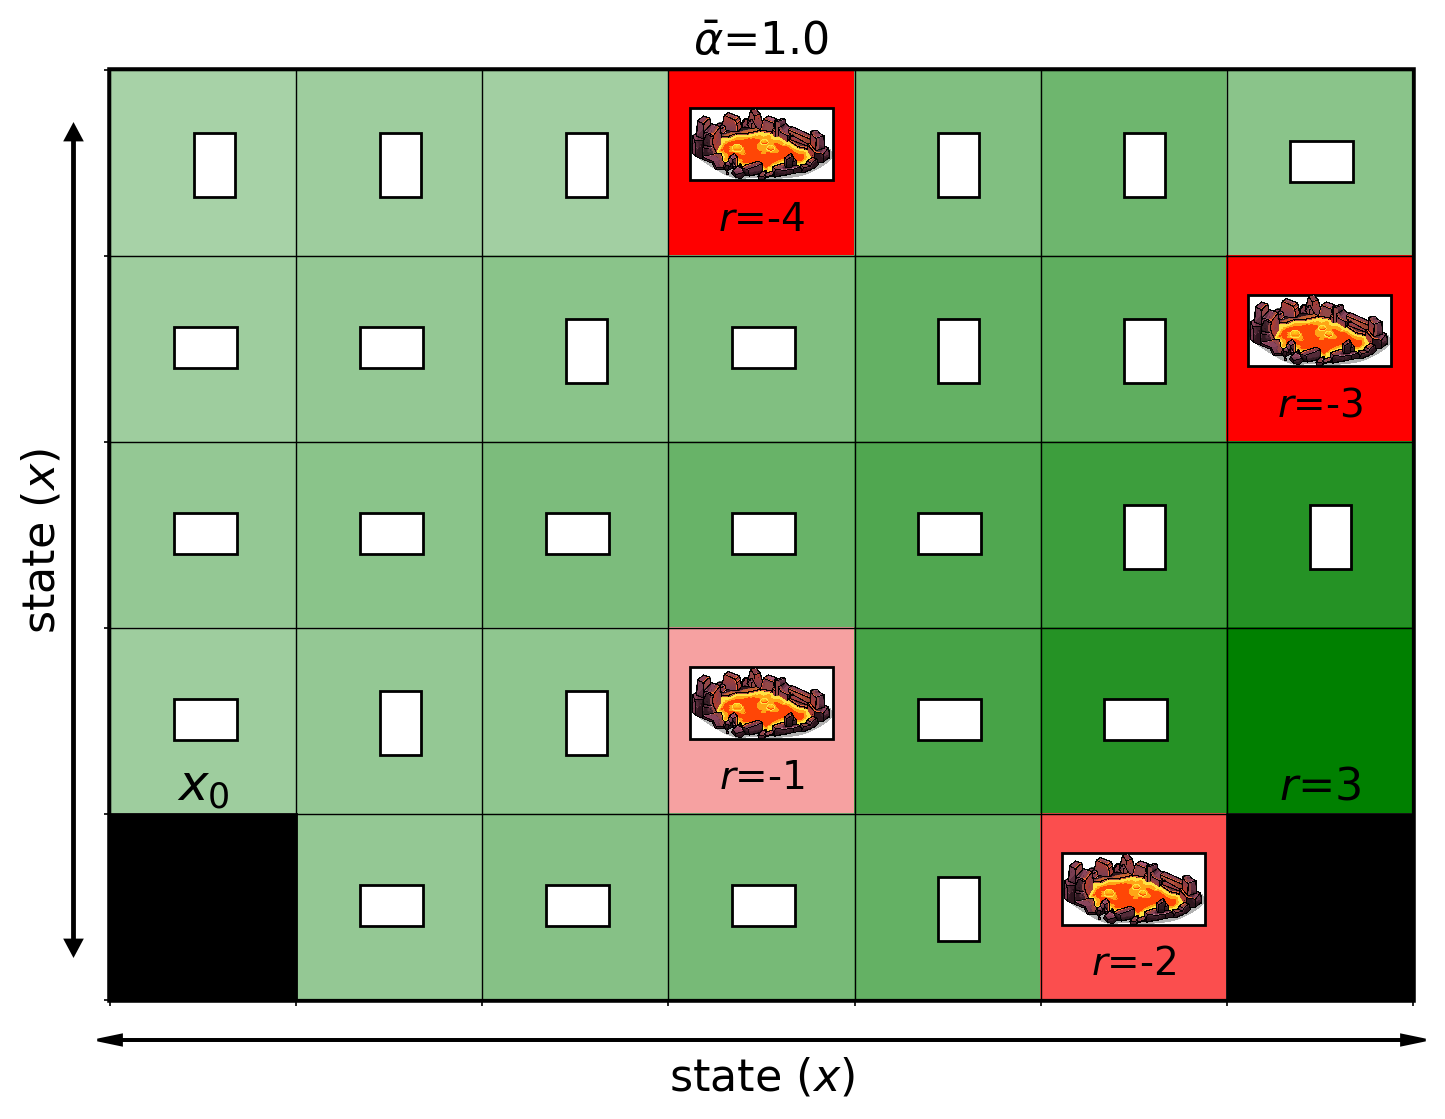

In [137]:
alpha_ind=5 #alpha = 1

alpha = y_set[alpha_ind]

# Plot 
fig,ax = plt.subplots(1,1,figsize=(8,5),dpi=200)
term_states_for_plotting=[3,13,24,27,28,33,33,34]
# term_states_for_plotting=[3,13,24,27,28,33,34]
Qrange = [-3,3]

# Value Underlay 
plot_q_or_pi(np.zeros_like(Pol_d_py[:,alpha_ind,:]),
             -1*Vd_py[:,alpha_ind].reshape(agent.maze.shape),
             '',ax,agent.maze,q_or_pi='q',
            roundoff=1,inc_triangles=False,
             tri_add_labels=False,annot_value=False,Qrange=Qrange,
             term_states_for_plotting=term_states_for_plotting,n_colors=100)


# Policy as Arrows

plot_2D_arrows(Pol_d_py[:,alpha_ind,:],
               alpha_ind,maze,question=True,
               term_states_for_plotting=term_states_for_plotting)

embellish_plot(ax,agent.maze,
    agent,None,
    cost=True,
    corner_labels=False,
    color_agent='b',
    center_rewards=False,
    r_fontsize=14,
    add_rewards=False,ec='white',fc='white',alpha=0.0,outer_lw=2,reward_color='k')

# added for lava pits
fs=16

x_pos = np.array([5, 3, 3, 6])
y_pos = np.array([4, 3, 0, 1])
rewards = np.array([-2, -1, -4, -3])
'''
x_pos = np.array([6, 5, 3])
y_pos = np.array([1, 4, 0])
rewards = np.array([-1, -4, -3])
'''
for i in range(4): 
    arr_img = mpimg.imread('/Users/katiemclaughlin/Downloads/cvar/mscl/lava_pit.png')
    imagebox = OffsetImage(arr_img , zoom=.013)
    ab = AnnotationBbox(imagebox, (x_pos[i], y_pos[i]-.1),pad=0)
    ax.add_artist(ab)
    
    plt.text(x_pos[i],y_pos[i]+0.3,r'$r$=%s'%(rewards[i]),fontsize=fs-2,zorder=10,va='center',ha='center',color='k')
    
'''

for i in range(1,6):
     plt.text(i,4.3,r'$r$=-1',fontsize=fs-2,zorder=10,va='center',ha='center',color='k')
'''
plt.text(6,3.35,'$r$=3',fontsize=fs,zorder=3,va='center',ha='center',color='k')
plt.text(0,3.35,r'$x_0$',fontsize=fs+2,zorder=3,va='center',ha='center',color='k')

plt.title(r'$\bar{\alpha}$='+str(np.round(alpha,2)),fontsize=fs)

# arrows
x0=0.1; y0=0
x1=0.9; y1=0
plt.arrow(x1,y1,x0-x1,y0-y1,transform=plt.gcf().transFigure,
         color='k',clip_on=False,head_width=.01)
plt.arrow(x0,y0,x1-x0,y1-y0,transform=plt.gcf().transFigure,
         color='k',clip_on=False,head_width=.01)
plt.text((x0+x1)/2,y0-0.05,r'state ($x$)',
             transform=plt.gcf().transFigure,clip_on=False,
             rotation=0,fontsize=fs,ha='center')

# arrows
x0=0.07; y0=0.1
x1=0.07; y1=0.9
plt.arrow(x1,y1,x0-x1,y0-y1,transform=plt.gcf().transFigure,
         color='k',clip_on=False,head_width=.01)
plt.arrow(x0,y0,x1-x0,y1-y0,transform=plt.gcf().transFigure,
         color='k',clip_on=False,head_width=.01)
plt.text(x0-0.02,(y0+y1)/2,r'state ($x$)',
             transform=plt.gcf().transFigure,clip_on=False,
             rotation=90,fontsize=fs,va='center',ha='center')


## Evaluation

Run optimal policy on original environment and calculate average reward over `episodes` number of iterations

In [12]:
####
# based on the action taken from position x
# returns x prime, x_p: the next state
####
def calculate_x_p(x, action):
    if action == 0 and x % 5 != 0: # up
        x_p = x - 1
    elif action == 1 and (x != 3 and (x + 1) % 5 != 0): # down
        x_p = x + 1
    elif action == 2 and x < 29: # right
        x_p = x + 5
    elif action == 3 and (x != 9 and x > 4): # left
        x_p = x - 5
    else:
        x_p = x
    
    return x_p

In [13]:
####
# step in environment with the following parameters:
#     x (int): current position
#     action (int): up (0), down (1), right (2), left (3) in line with optimal policy pi       
#     P (np array): transition probability matrix
#     r (np array): rewards matrix
# returns the following variables:
#     x_p (int): x_prime, the next position
#     is_done (boolean): true if successfully completes end of maze or hit a lava pit
####
def step(x, action, P, r):
    # calculate next position from x according to action
    x_p = calculate_x_p(x, action)
    ##print('Intended x prime: {0}'.format(x_p))
    
    # draw from a random uniform distribution and see if slippery-ness takes hold
    rand_prob = random.uniform(0, 1) 
    bucket_arr = np.cumsum(P[x][x_p])
    ##print('Probability: {0}.  Array: {1}'.format(rand_prob, bucket_arr))
    
    # see where step actually ends up
    if rand_prob < bucket_arr[0]: # up
        ##print('Going up')
        x_p = calculate_x_p(x, 0)
    elif rand_prob < bucket_arr[1]: # down
        ##print('Going down')
        x_p = calculate_x_p(x, 1)
    elif rand_prob < bucket_arr[2]: # right
        ##print('Going right')
        x_p = calculate_x_p(x, 2)
    else: # left
        ##print('Going left')
        x_p = calculate_x_p(x, 3)
    
    ## print('Actual x prime: {0}'.format(x_p))
    # check if x_p is a lava pit or a successful finish
    if np.array_equal(P[x_p][35], np.ones(4)):
        return x_p, True
    else:
        return x_p, False

In [94]:
# set alpha values
alpha_ind = 3
alpha = y_set[alpha_ind]

# reshape optimal policy from graphing Pol_d_py into pi so that indexing aligns with P
last_row = Pol_d_py[:,alpha_ind,:][34]

pi = np.transpose(Pol_d_py[:,alpha_ind,:35].reshape(5, 7, 4), (1, 0, 2)).reshape(35, 4)
pi = np.append(pi, last_row.reshape(1, 4), axis=0)

In [95]:
# run through environment and calculate average reward

num_iters = 20000 # number of iterations

total_rewards = 0
all_rewards = []

for i_iter in range(num_iters):
    x = 3 # start index
    reward = 0
    is_done = False
    
    # run agent
    while not is_done:
        # try to step in direction of optimal policy with gamma = 0.9
        action = np.where(pi[x] == 1)[0][0]
        x, is_done = step(x, action, P_orig, r_orig)
        
        # check to see if episode is done
        if is_done:
            reward = r_orig[x][0]
    
    all_rewards.append(reward)
    total_rewards += reward

print('Average reward for {0} iterations: {1:.2f}'.format(num_iters, total_rewards/num_iters))

Average reward for 20000 iterations: -1.54


In [81]:
# run this cell with correct variable to save corresponding values
# rewards_full_a1, rewards_full_a6, rewards_full_a3, rewards_curr_a1, rewards_curr_a6, rewards_curr_a3

rewards_curr_a3 = all_rewards.copy() 

## Statistical Significance

In [213]:
# ANOVA between three alpha values in same configuration
# anova_p = f_oneway(rewards_full_a1, rewards_full_a6, rewards_full_a3).pvalue
anova_p = f_oneway(rewards_curr_a1, rewards_curr_a6, rewards_curr_a3).pvalue
print('p value = {0:.5f}'.format(anova_p))

p value = 0.78088


In [214]:
# t-test between configuration and respective alpha-level configuration in all
t_1 = ttest_ind(rewards_full_a1, rewards_curr_a1).pvalue
t_6 = ttest_ind(rewards_full_a6, rewards_curr_a6).pvalue
t_3 = ttest_ind(rewards_full_a3, rewards_curr_a3).pvalue
print('p_1 = {0:.3f}'.format(t_1))
print('p_0.6 = {0:.3f}'.format(t_6))
print('p_0.3 = {0:.3f}'.format(t_3))

p_1 = 0.000
p_0.6 = 0.000
p_0.3 = 0.000


## Calculate CVaR

In [120]:
# set alpha value
tail_alpha = 0.2
tail_index = int(tail_alpha * len(all_rewards))

# isolate lower tail
all_rewards.sort()
lower_tail = all_rewards[:tail_index]

# calcualte CVaR mean of lower alpha tail
mean = np.mean(lower_tail)
print('CVaR alpha={0:.1f} Mean = {1:.2f}'.format(tail_alpha, mean))

CVaR alpha=0.2 Mean = -2.01


In [121]:
rewards_curr_a1.sort()
lower_a1 = rewards_curr_a1[:tail_index]

rewards_curr_a6.sort()
lower_a6 = rewards_curr_a6[:tail_index]

rewards_curr_a3.sort()
lower_a3 = rewards_curr_a3[:tail_index]

In [124]:
ttest_ind(lower_a6,lower_a1).pvalue

0.0

## Graph Distribution of Rewards

In [96]:
bins = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
counts, bins = np.histogram(all_rewards, bins = bins)
from matplotlib.ticker import PercentFormatter

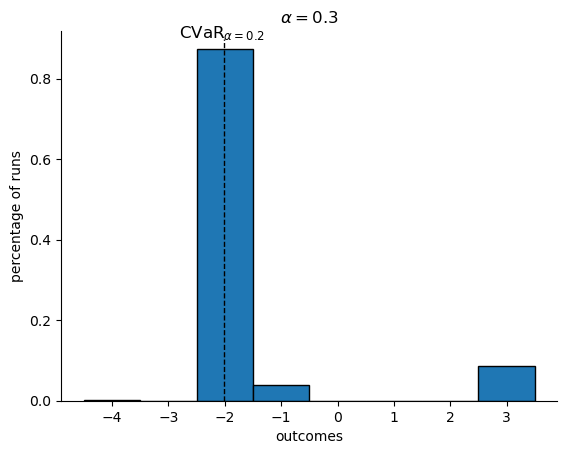

In [103]:
fig, ax = plt.subplots()

# distribution
plt.hist(all_rewards, bins = bins, density=True, edgecolor='k', align='left')

# CVaR Line #
plt.axvline(x=-2.01,
            ymax=0.98,
            color='k',linestyle='--',linewidth=1,zorder=3)
plt.text(-2.01-0.8,
         0.9,r'CVaR$_{\alpha=0.2}$',fontsize=12)

# formatting
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('outcomes')
plt.ylabel('percentage of runs')
plt.title(r'$\alpha=0.3$')

plt.show()